### 3.3.2 - Decision Tree Training



In [1]:


#this is for development only and not relevant
%load_ext autoreload
%autoreload


## lets load the data
from utils.helpers import *
df_red, df_white, df_all = pull_and_load_data(force = False)

# create a X_train that is just the features and the associated
# classes (labels) that have been convered to binary classes -- "not good wine", "good wine"
# as described before
X_train, y_train = get_features_and_labels(df_all, binary = True)

path exist and not forced
path exist and not forced


In [2]:

from sklearn import tree
X = X_train
Y = y_train
clf = tree.DecisionTreeClassifier(
    criterion = 'entropy',# 'gini', #entropy
    max_depth = 3,
    )

clf = clf.fit(X, Y)



In [3]:
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

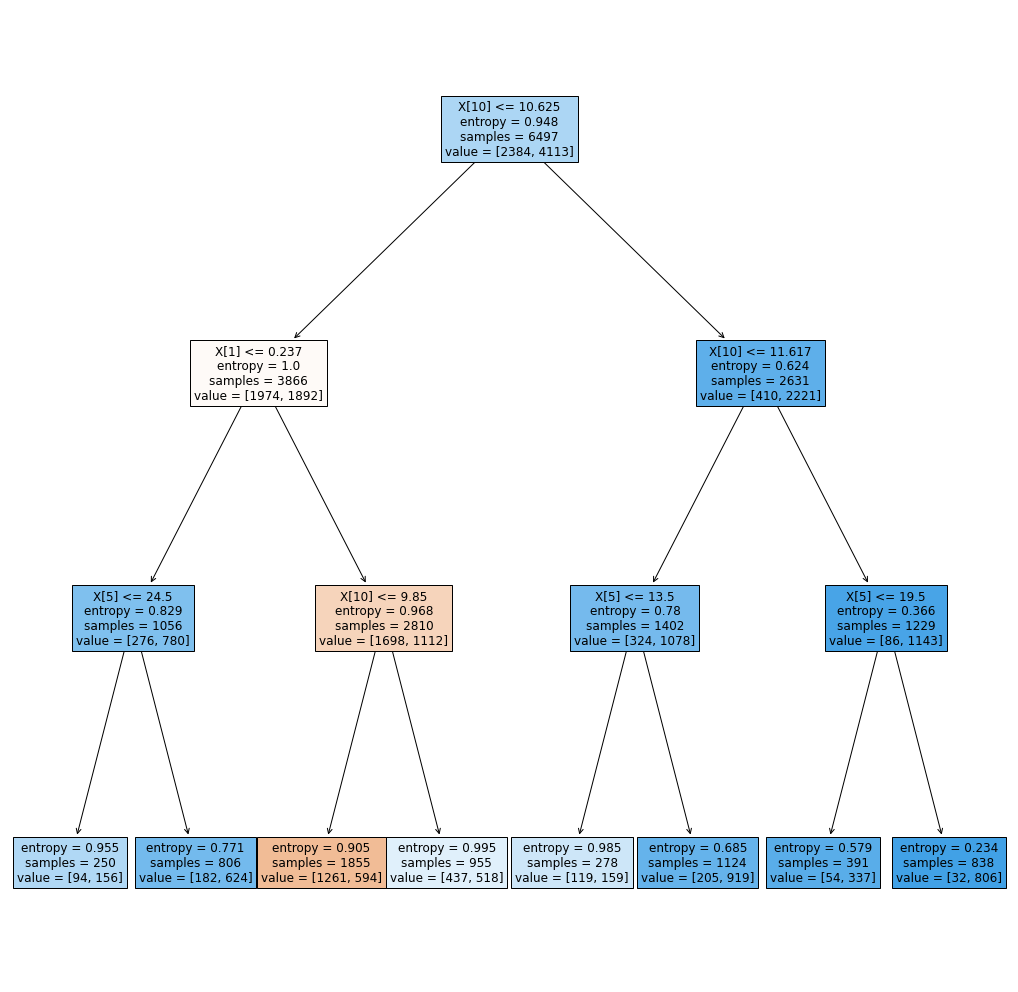

In [4]:

figsize = 18, 18
plt.figure(figsize = figsize)

tree.plot_tree(clf, filled=True, fontsize=12)
plt.show()

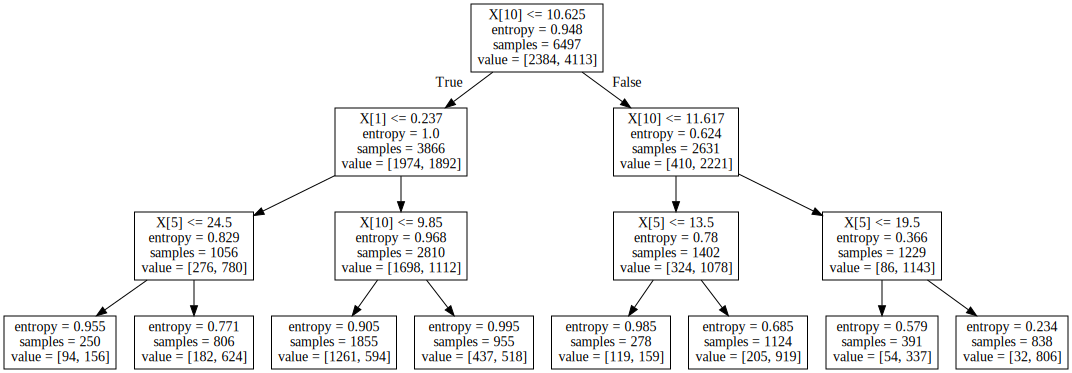

In [5]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

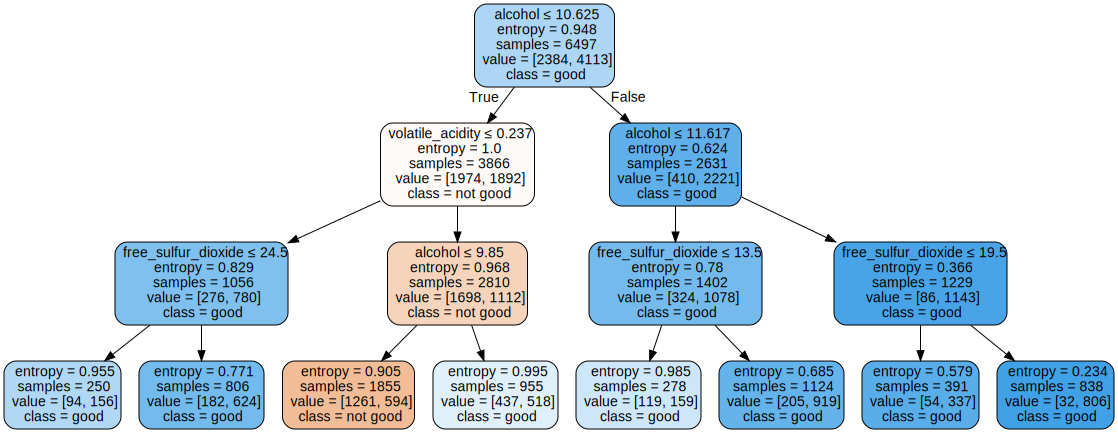

In [6]:
feature_names = ["fixed_acidity", "volatile_acidity", "citric_acid", \
                     "residual_sugar", "chlorides", "free_sulfur_dioxide", \
                     "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"]

dot_data = tree.export_graphviz(clf, out_file = None, 
                     feature_names = feature_names,
                     class_names = ['not good', 'good'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

In [7]:
y_train

0       0
1       0
2       0
3       1
4       0
       ..
6492    1
6493    0
6494    1
6495    1
6496    1
Length: 6497, dtype: int64

In [8]:
# verification:

y_train[ (X_train['alcohol'] <= 10.625).to_numpy()]

lt = y_train[ (X_train['alcohol'] <= 10.625).to_numpy()]

np.bincount(lt)

array([1974, 1892])

https://www.kaggle.com/rajyellow46/decision-tree-analysis-of-wine-quality-data

meh: https://rstudio-pubs-static.s3.amazonaws.com/227997_869ca5f2dc144f7b85cdbc3f45a47bb6.html

https://airoot.github.io/Predictive-Wine-Quality-System/

https://medium.com/themlblog/wine-quality-prediction-using-machine-learning-59c88a826789

https://www.slideshare.net/MohammedAlHamadi1/predicting-wine-quality-using-different-implementations-of-decision-tree-algorithm-in-r


In [9]:
clf.score(X_train, y_train)

0.7357241803909497